# X/Twitter Cleaning

In [22]:
import json
import csv
import os
import re

def clean_text(text):
    """Clean text by removing unusual line terminators and normalizing whitespace"""
    if not isinstance(text, str):
        return text
    
    # Remove Line Separator (LS) and Paragraph Separator (PS) characters
    text = text.replace('\u2028', ' ')  # Line Separator
    text = text.replace('\u2029', ' ')  # Paragraph Separator
    
    # Remove other unusual whitespace characters
    text = text.replace('\u00A0', ' ')  # Non-breaking space
    text = text.replace('\u2000', ' ')  # En quad
    text = text.replace('\u2001', ' ')  # Em quad
    text = text.replace('\u2002', ' ')  # En space
    text = text.replace('\u2003', ' ')  # Em space
    text = text.replace('\u2004', ' ')  # Three-per-em space
    text = text.replace('\u2005', ' ')  # Four-per-em space
    text = text.replace('\u2006', ' ')  # Six-per-em space
    text = text.replace('\u2007', ' ')  # Figure space
    text = text.replace('\u2008', ' ')  # Punctuation space
    text = text.replace('\u2009', ' ')  # Thin space
    text = text.replace('\u200A', ' ')  # Hair space
    text = text.replace('\u200B', '')   # Zero width space
    text = text.replace('\u200C', '')   # Zero width non-joiner
    text = text.replace('\u200D', '')   # Zero width joiner
    text = text.replace('\u2060', '')   # Word joiner
    
    # Normalize multiple spaces to single space
    text = re.sub(r'\s+', ' ', text)
    
    # Strip leading/trailing whitespace
    text = text.strip()
    
    return text

In [23]:
import pandas as pd

# Read the dataset
df = pd.read_csv('../data/AAPL/AAPL_tweets_2020-10-01_2025-10-01.csv')

print(f"Original dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")


Original dataset shape: (38553, 17)
Columns: ['symbol', 'tweet_id', 'text', 'created_at', 'user_id', 'username', 'user_name', 'retweet_count', 'like_count', 'reply_count', 'quote_count', 'view_count', 'is_reply', 'conversation_id', 'url', 'lang', 'search_date']


In [24]:
# Apply the cleaning function to the text column
print("Cleaning text column...")
df['text_cleaned'] = df['text'].apply(clean_text)
print("Cleaning completed!")

Cleaning text column...
Cleaning completed!


In [25]:
# Replace the original text column with the cleaned version
df['text'] = df['text_cleaned']

# Drop the temporary 'text_cleaned' column
df = df.drop('text_cleaned', axis=1)

# Keep only the specified columns
df = df[['created_at', 'text', 'like_count', 'retweet_count']]

# Save the cleaned and filtered dataset
output_path = '../data/AAPL/AAPL_tweets_clean.csv'
df.to_csv(output_path, index=False)

print(f"Cleaned dataset saved to: {output_path}")
print(f"Final columns: {df.columns.tolist()}")
print(f"File size: {os.path.getsize(output_path) / (1024*1024):.2f} MB")


Cleaned dataset saved to: ../data/AAPL/AAPL_tweets_clean.csv
Final columns: ['created_at', 'text', 'like_count', 'retweet_count']
File size: 7.43 MB


# Stock Market CSV Cleaning

In [26]:
# Load the stock market data
market_df = pd.read_csv('../data/AAPL/AAPL_2020-10-01 00:00:00_2025-10-01 00:00:00.csv')

print(f"Original market data shape: {market_df.shape}")
print(f"Original market data columns: {market_df.columns.tolist()}")

# Keep only the specified columns
market_df = market_df[['Date', 'Open', 'Close']]

# Convert column headers to lowercase
market_df.columns = market_df.columns.str.lower()

# Save the cleaned market dataset
market_output_path = '../data/AAPL/AAPL_market_clean.csv'
market_df.to_csv(market_output_path, index=False)

print(f"Cleaned market dataset saved to: {market_output_path}")
print(f"Final market data columns: {market_df.columns.tolist()}")
print(f"Market data file size: {os.path.getsize(market_output_path) / (1024*1024):.2f} MB")

Original market data shape: (1255, 6)
Original market data columns: ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
Cleaned market dataset saved to: ../data/AAPL/AAPL_market_clean.csv
Final market data columns: ['date', 'open', 'close']
Market data file size: 0.06 MB


# Initial EDA


In [27]:
# Install and import required libraries for sentiment analysis and plotting
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Install vaderSentiment if not already installed
try:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
except ImportError:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "vaderSentiment"])
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

print("Libraries imported successfully!")


Libraries imported successfully!


In [28]:
# Load the cleaned datasets
df = pd.read_csv('../data/AAPL/AAPL_tweets_clean.csv')
market_df = pd.read_csv('../data/AAPL/AAPL_market_clean.csv')

print(f"Tweet data shape: {df.shape}")
print(f"Market data shape: {market_df.shape}")

# Convert date columns to datetime
df['created_at'] = pd.to_datetime(df['created_at'])
market_df['date'] = pd.to_datetime(market_df['date'])

# Extract date from created_at for matching
df['date'] = df['created_at'].dt.date
market_df['date'] = market_df['date'].dt.date

print("Date columns converted successfully!")


Tweet data shape: (38553, 4)
Market data shape: (1255, 3)
Date columns converted successfully!


In [29]:
# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Calculate sentiment scores for each tweet
print("Calculating sentiment scores...")
df['sentiment_scores'] = df['text'].apply(lambda x: analyzer.polarity_scores(str(x)))
df['sentiment_compound'] = df['sentiment_scores'].apply(lambda x: x['compound'])
df['sentiment_positive'] = df['sentiment_scores'].apply(lambda x: x['pos'])
df['sentiment_negative'] = df['sentiment_scores'].apply(lambda x: x['neg'])
df['sentiment_neutral'] = df['sentiment_scores'].apply(lambda x: x['neu'])

print("Sentiment analysis completed!")
print(f"Sentiment compound score range: {df['sentiment_compound'].min():.3f} to {df['sentiment_compound'].max():.3f}")
print(f"Average sentiment: {df['sentiment_compound'].mean():.3f}")


Calculating sentiment scores...
Sentiment analysis completed!
Sentiment compound score range: -0.995 to 0.999
Average sentiment: 0.158


In [30]:
# Prepare data for sentiment vs price analysis
# Aggregate sentiment by date
daily_sentiment = df.groupby('date').agg({
    'sentiment_compound': 'mean',
    'like_count': 'sum',
    'retweet_count': 'sum',
    'text': 'count'  # tweet count
}).reset_index()

daily_sentiment.columns = ['date', 'avg_sentiment', 'total_likes', 'total_retweets', 'tweet_count']

# Merge with market data
sentiment_price_data = pd.merge(daily_sentiment, market_df, on='date', how='inner')

# Calculate daily price change
sentiment_price_data['price_change'] = sentiment_price_data['close'] - sentiment_price_data['open']
sentiment_price_data['price_change_pct'] = (sentiment_price_data['price_change'] / sentiment_price_data['open']) * 100

print(f"Combined dataset shape: {sentiment_price_data.shape}")
print(f"Date range: {sentiment_price_data['date'].min()} to {sentiment_price_data['date'].max()}")


Combined dataset shape: (1223, 9)
Date range: 2020-10-01 to 2025-09-30


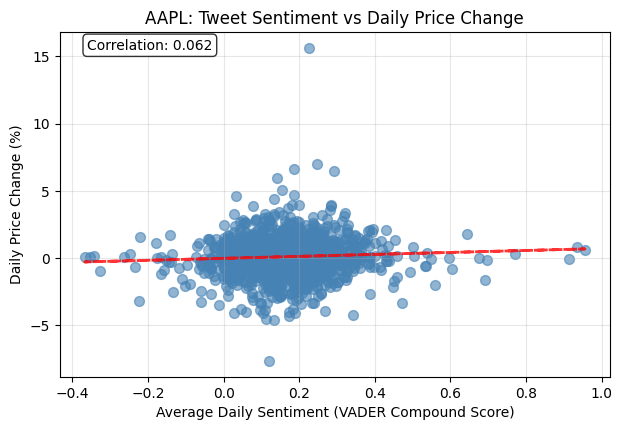

Correlation between sentiment and price change: 0.062


In [31]:
# Plot 1: Sentiment vs Price Change
plt.figure(figsize=(12, 8))

# Create subplot
plt.subplot(2, 2, 1)
plt.scatter(sentiment_price_data['avg_sentiment'], sentiment_price_data['price_change_pct'], 
           alpha=0.6, s=50, c='steelblue')
plt.xlabel('Average Daily Sentiment (VADER Compound Score)')
plt.ylabel('Daily Price Change (%)')
plt.title('AAPL: Tweet Sentiment vs Daily Price Change')
plt.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(sentiment_price_data['avg_sentiment'], sentiment_price_data['price_change_pct'], 1)
p = np.poly1d(z)
plt.plot(sentiment_price_data['avg_sentiment'], p(sentiment_price_data['avg_sentiment']), 
         "r--", alpha=0.8, linewidth=2)

# Calculate correlation
correlation = sentiment_price_data['avg_sentiment'].corr(sentiment_price_data['price_change_pct'])
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=plt.gca().transAxes, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.tight_layout()
plt.show()

print(f"Correlation between sentiment and price change: {correlation:.3f}")


In [32]:
# Calculate price volatility (rolling standard deviation of daily returns)
sentiment_price_data = sentiment_price_data.sort_values('date')
sentiment_price_data['daily_return'] = sentiment_price_data['close'].pct_change()
sentiment_price_data['volatility_5d'] = sentiment_price_data['daily_return'].rolling(window=5).std()
sentiment_price_data['volatility_10d'] = sentiment_price_data['daily_return'].rolling(window=10).std()

# Calculate total engagement (likes + retweets)
sentiment_price_data['total_engagement'] = sentiment_price_data['total_likes'] + sentiment_price_data['total_retweets']

# Remove rows with NaN values for volatility
volatility_data = sentiment_price_data.dropna(subset=['volatility_5d', 'volatility_10d'])

print(f"Volatility data shape: {volatility_data.shape}")
print(f"Average 5-day volatility: {volatility_data['volatility_5d'].mean():.4f}")
print(f"Average total engagement: {volatility_data['total_engagement'].mean():.0f}")


Volatility data shape: (1213, 13)
Average 5-day volatility: 0.0159
Average total engagement: 180


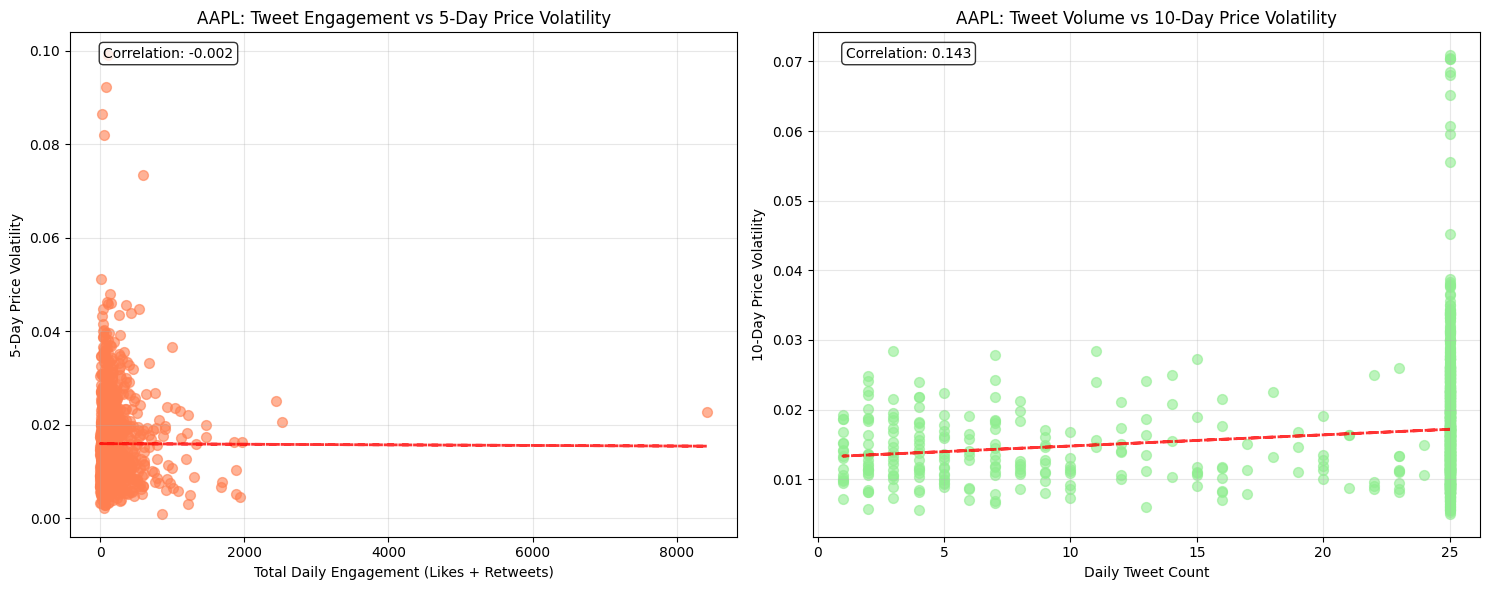

Correlation between engagement and 5-day volatility: -0.002
Correlation between tweet count and 10-day volatility: 0.143


In [33]:
# Plot 2: Engagement vs Price Volatility
plt.figure(figsize=(15, 6))

# Subplot 1: Total Engagement vs 5-day Volatility
plt.subplot(1, 2, 1)
plt.scatter(volatility_data['total_engagement'], volatility_data['volatility_5d'], 
           alpha=0.6, s=50, c='coral')
plt.xlabel('Total Daily Engagement (Likes + Retweets)')
plt.ylabel('5-Day Price Volatility')
plt.title('AAPL: Tweet Engagement vs 5-Day Price Volatility')
plt.grid(True, alpha=0.3)

# Add trend line
z1 = np.polyfit(volatility_data['total_engagement'], volatility_data['volatility_5d'], 1)
p1 = np.poly1d(z1)
plt.plot(volatility_data['total_engagement'], p1(volatility_data['total_engagement']), 
         "r--", alpha=0.8, linewidth=2)

# Calculate correlation
correlation_5d = volatility_data['total_engagement'].corr(volatility_data['volatility_5d'])
plt.text(0.05, 0.95, f'Correlation: {correlation_5d:.3f}', transform=plt.gca().transAxes, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# Subplot 2: Tweet Count vs 10-day Volatility
plt.subplot(1, 2, 2)
plt.scatter(volatility_data['tweet_count'], volatility_data['volatility_10d'], 
           alpha=0.6, s=50, c='lightgreen')
plt.xlabel('Daily Tweet Count')
plt.ylabel('10-Day Price Volatility')
plt.title('AAPL: Tweet Volume vs 10-Day Price Volatility')
plt.grid(True, alpha=0.3)

# Add trend line
z2 = np.polyfit(volatility_data['tweet_count'], volatility_data['volatility_10d'], 1)
p2 = np.poly1d(z2)
plt.plot(volatility_data['tweet_count'], p2(volatility_data['tweet_count']), 
         "r--", alpha=0.8, linewidth=2)

# Calculate correlation
correlation_10d = volatility_data['tweet_count'].corr(volatility_data['volatility_10d'])
plt.text(0.05, 0.95, f'Correlation: {correlation_10d:.3f}', transform=plt.gca().transAxes, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.tight_layout()
plt.show()

print(f"Correlation between engagement and 5-day volatility: {correlation_5d:.3f}")
print(f"Correlation between tweet count and 10-day volatility: {correlation_10d:.3f}")


In [34]:
# Summary statistics
print("=== EDA SUMMARY ===")
print(f"Dataset period: {sentiment_price_data['date'].min()} to {sentiment_price_data['date'].max()}")
print(f"Total trading days analyzed: {len(sentiment_price_data)}")
print(f"Total tweets analyzed: {len(df):,}")
print(f"Average tweets per day: {len(df) / len(sentiment_price_data):.1f}")
print()
print("=== CORRELATION RESULTS ===")
print(f"Sentiment vs Price Change: {correlation:.3f}")
print(f"Engagement vs 5-day Volatility: {correlation_5d:.3f}")
print(f"Tweet Count vs 10-day Volatility: {correlation_10d:.3f}")
print()
print("=== SENTIMENT STATISTICS ===")
print(f"Average daily sentiment: {sentiment_price_data['avg_sentiment'].mean():.3f}")
print(f"Sentiment range: {sentiment_price_data['avg_sentiment'].min():.3f} to {sentiment_price_data['avg_sentiment'].max():.3f}")
print(f"Most positive day: {sentiment_price_data.loc[sentiment_price_data['avg_sentiment'].idxmax(), 'date']} ({sentiment_price_data['avg_sentiment'].max():.3f})")
print(f"Most negative day: {sentiment_price_data.loc[sentiment_price_data['avg_sentiment'].idxmin(), 'date']} ({sentiment_price_data['avg_sentiment'].min():.3f})")


=== EDA SUMMARY ===
Dataset period: 2020-10-01 to 2025-09-30
Total trading days analyzed: 1223
Total tweets analyzed: 38,553
Average tweets per day: 31.5

=== CORRELATION RESULTS ===
Sentiment vs Price Change: 0.062
Engagement vs 5-day Volatility: -0.002
Tweet Count vs 10-day Volatility: 0.143

=== SENTIMENT STATISTICS ===
Average daily sentiment: 0.162
Sentiment range: -0.368 to 0.956
Most positive day: 2024-05-24 (0.956)
Most negative day: 2024-08-08 (-0.368)
